LSTM(Long Short-Term Memory) 구조
- 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러개 가지고 있다.
- 은닉상태는 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다.
  이때, 기본 순환층과는 달리 시그모이드 활성화 함수 사용.
  또 tanh 활성화 함수를 통과한 어떤 값과 곱해져서 은닉 상태를 만든다.
- 순환되는 상태가 2개.
  은닉상태와 달리 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 셀 상태라고 부르는 값
  ** 셀상태를 계산하는 과정: 1. 먼저 입력과 은닉 상태를 또 다른 가중치에 곱한 다음 시그모이드 함수를 통과시킨다.
                             2. 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다.
                                (이셀 상태가 tanh 함수를 통과하여 새로운 은닉 상태를 만드는데 기여함)
                             3. 여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는데 기여.
                                (이전과 마찬가지고 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나는 시그모이드 함수를 통과시키고
                                 다른 하나는 tanh 함수를 통과시킨 후 두 결과를 곱한 후 이전 셀 상태와 더한 결과가 최종적인 다음 셀 상                                    태가 된다.)


- 삭제게이트: 셀 상태에 있는 정보를 제거
- 입력게이트: 새로운 정보를 셀 상태에 추가
- 출력게이트: 다음 은닉 상태로 출력

LSTM 신경망 훈련하기

In [3]:
# 500개의 단어를 사용하여 훈련세트와 검증 세트 나누기
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_inut, test_target) = imdb.load_data(num_words=500)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

In [4]:
# 길이를 100으로 맞추고 부족할때는 패딩추가
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [7]:
from tensorflow import keras
model=keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 모델 컴파일, 훈련
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5', save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history=model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 6s 11ms/step - loss: 0.6923 - accuracy: 0.5419 - val_loss: 0.6911 - val_accuracy: 0.5720
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6885 - accuracy: 0.6198 - val_loss: 0.6854 - val_accuracy: 0.6390
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6772 - accuracy: 0.6646 - val_loss: 0.6653 - val_accuracy: 0.6846
Epoch 4/100
313/313 [==============================] - 3s 8ms/step - loss: 0.6235 - accuracy: 0.7068 - val_loss: 0.5906 - val_accuracy: 0.7338
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5699 - accuracy: 0.7381 - val_loss: 0.5637 - val_accuracy: 0.7426
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5449 - accuracy: 0.7535 - val_loss: 0.5429 - val_accuracy: 0.7606
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5250 - accuracy: 0.7645 - val_loss: 0.5246 - val_accuracy: 0.767

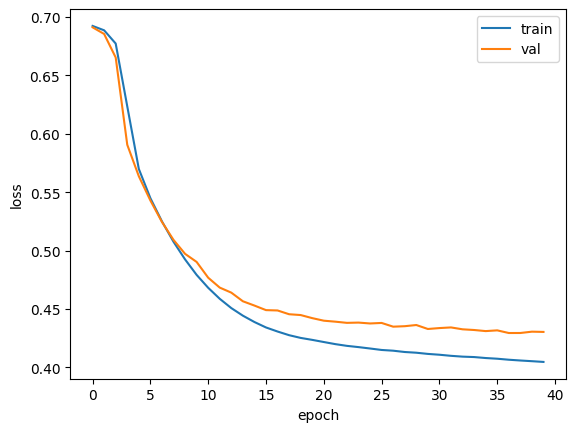

In [10]:
# 훈련손실, 검증손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

순환층에 드롭아웃 적용하기
-순환층은 자체적으로 드롭아웃 기능 제공.
-SimpleRNN과 LSTM 모두 dropout 매개변수와 recurrent_dropout 매개변수를 가지고 있다.
-dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고, recurrent_dropout(GPU를 사용하여 모델 훈련할수 없음)은 순환되는 은닉상태에 드롭아웃 적용.


In [11]:
model2=keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [15]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-dropout-model.h5', save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
history=model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 5s 10ms/step - loss: 0.6925 - accuracy: 0.5429 - val_loss: 0.6918 - val_accuracy: 0.5932
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6905 - accuracy: 0.6032 - val_loss: 0.6891 - val_accuracy: 0.6332
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6845 - accuracy: 0.6471 - val_loss: 0.6787 - val_accuracy: 0.6428
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6523 - accuracy: 0.6681 - val_loss: 0.6256 - val_accuracy: 0.7190
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 0.6083 - accuracy: 0.7235 - val_loss: 0.6006 - val_accuracy: 0.7182
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5864 - accuracy: 0.7312 - val_loss: 0.5809 - val_accuracy: 0.7428
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 0.5684 - accuracy: 0.7452 - val_loss: 0.5612 - val_accuracy: 0.748

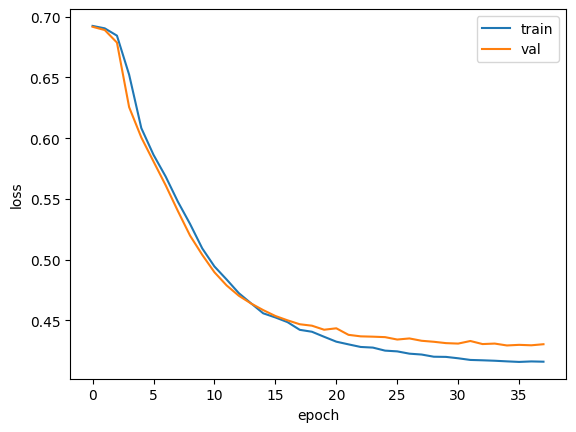

In [16]:
# 훈련손실, 검증손실 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()